In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import time

# Working directory setzen
current_dir = os.getcwd()
os.chdir(current_dir)

## Tester hilfsfunktionen

In [5]:
def is_lb_bellow_ub(lb_line, ub_line):
    """
    Testet, ob eine Lower Bound Linie (lb) unterhalb des Bereiches einer Upper Bound Linie (ub) liegt.
    Annahme: lb und ub sind Linien, dessen x-Intervalle sich schneiden
    Annahme: lb-linien haben keine positive Steigung (i.e. Steigung <= 0)
    Annahme: ub-linien haben keine positive Steigung (i.e. Steigung <= 0)
    :param lb_line: Lower Bound Linie
    :param ub_line: Upper Bound Linie
    :return: True, falls die Lower Bound Linie unterhalb der Upper Bound Linie liegt, sonst False
    """

    # Upper / Lower , Start / End
    u_s = ub_line[0]
    u_e = ub_line[1]
    l_s = lb_line[0]
    l_e = lb_line[1]

    # Berechne y= mx + b für beide Linien
    u_m = (u_e[1]-u_s[1])/(u_e[0]-u_s[0]) if u_e[0] != u_s[0] else np.inf
    u_b = u_s[1] - u_m*u_s[0]
    l_m = (l_e[1]-l_s[1])/(l_e[0]-l_s[0]) if l_e[0] != l_s[0] else np.inf
    l_b = l_s[1] - l_m*l_s[0]

    # Berechne die Schnittmenge der x-Intervalle
    x_s = max(u_s[0], l_s[0])
    x_e = min(u_e[0], l_e[0])

    #Berechne die y-Werte der Linien an den x-Werten x_s und x_e
    u_x_s_y = u_m*x_s + u_b
    u_x_e_y = u_m*x_e + u_b

    l_x_s_y = l_m*x_s + l_b
    l_x_e_y = l_m*x_e + l_b

    # Teste, ob die Lower Bound Linie unterhalb der Upper Bound Linie liegt
    return l_x_s_y < u_x_s_y or l_x_e_y < u_x_e_y

    

def adjust_ub_line(po_ub_raw):
        """
        Passt die Upper Bound Linien an:
        1. pos. Steigung entfernen (eine Steigung von 0 ist erlaubt und nie schlechter)
        2. monoton machen (y-Werte einer Line (mit größerem x-Wert) darf für den Algo nicht größer werden) (ist erlaubt und nie schlechter)
        3. neg. Steigung entfernen (eine negative Steigung der upper bounds ist nicht erlaubt)

        Wir speichern die Flags, ob eine Anpassung gemacht wurde -> kann uns helfen, die Heuristik zu verstehen&verbessern

        :param po_ub: Upper Bound Linien
        :return: Flags, ob eine Anpassung gemacht wurde
        """
        ub_pos_flag, ub_mon_flag, ub_bb_flag = False, False, False
        lowest_y = np.inf

        po_ub = po_ub_raw.copy()

        for line in po_ub:
            # pos. Steigung entfernen
            if line[0][1] < line[1][1]:
                line[1][1] = line[0][1]
                ub_pos_flag = True

            # monoton machen
            if line[0][1] > lowest_y:
                line[0][1] = lowest_y
                ub_mon_flag = True

            if line[1][1] > lowest_y:
                line[1][1] = lowest_y
            else: # line[1][1] <= lowest_y
                lowest_y = line[1][1]

            # neg. Steigung entfernen
            if line[0][1] > line[1][1]:
                line[1][1] = line[0][1]
                ub_bb_flag = True
        return po_ub, ub_pos_flag, ub_mon_flag, ub_bb_flag

## Tester

In [6]:

    

def heuristic_test(bigger_df, smaller_df, bigger_lb_func, smaller_lb_func, po_heuristic_func, po_ub_func):
    """
    Testet wie effektiv die Heuristik ist.
    :param bigger_df: größere Menge von Punkten (DataFrame)
    :param smaller_df: kleinere Menge von Punkten (DataFrame)
    :param bigger_lb_func: Funktion zur Berechnung der Lower Bound Linien der größeren Menge
    :param smaller_lb_func: Funktion zur Berechnung der Lower Bound Linien der kleineren Menge
    :param po_heuristic_func: Funktion zur Berechnung der PO-Punkte Heuristik
    :param po_ub_func: Funktion zur Berechnung der Upper Bound Linien der PO-Punkte Heuristik
    """
    start_time = time.time()

    
    

    bigger_points = bigger_df[['weight_0', 'weight_1']].to_numpy()
    smaller_points = smaller_df[['weight_0', 'weight_1']].to_numpy()
    
    # lower, upper bounds bestimmen
    bigger_lb = bigger_lb_func(bigger_points) # Lower Bound für die größere Menge
    smaller_lb = smaller_lb_func(smaller_points) # Lower Bound für die kleinere Menge
    
    heuristic_points = po_heuristic_func(bigger_points, smaller_points) # PO-Heuristik Menge
    po_ub = po_ub_func(heuristic_points) # Upper Bound für die PO Heuristik Menge

    po_ub = np.array(po_ub)

    # po ub anpassen
    
    # Mengen zum plotten speichern 
    skip_lines = []
    calc_lines = []


    # Über alle Kombinationen von lower bound Linien iterieren (testen, ob kombinierte Linie oberhalb der Upper Lines liegt)
    # Wir ignorieren den weight_overlap, bzw. nehmen einen von (0,0) an, da es in der Berechnung keine Rolle spielt
    num_skip_line_comb = 0
    num_skip_point_comb = 0
    num_calc_line_comb = 0
    num_calc_point_comb = 0
    for s_line in smaller_lb:
        for b_line in bigger_lb:
            (A0, A1), s_start_idx, s_end_idx = s_line
            (B0, B1), b_start_idx, b_end_idx = b_line

            A0, A1, B0, B1 = np.array(A0), np.array(A1), np.array(B0), np.array(B1)

            # Die kombinierte Linie lb_line berechnen

            # Steigungen berechnen
            slope_A = (A1[1] - A0[1]) / (A1[0] - A0[0]) if A1[0] != A0[0] else np.inf
            slope_B = (B1[1] - B0[1]) / (B1[0] - B0[0]) if B1[0] != B0[0] else np.inf
            
            # o.b.d.a. slope_A <= slope_B
            if slope_A > slope_B:
                tmp_A0, tmp_A1 = A0, A1
                A0, A1 = B0, B1
                B0, B1 = tmp_A0, tmp_A1
            
            lb_line = [A0 + B0, A1 + B0, A1 + B1]

            test_a, test_b = None, None

            #skip_combination flag ist True, bis bewiesen wird, dass die kombinierte Linie nicht übersprungen werden kann
            skip_combination = True

            # testen, ob die kombinierte Line vor der Heuristik anfängt -> dürfen nicht überspringen
            if lb_line[0][0] < po_ub[0,0,0]:
                skip_combination = False
            # testen, ob die kombinierte Line nach der letzten ub endet und unterhalb der letzten ub Linie liegt -> dürfen nicht übersprungen
            elif lb_line[2][0] > po_ub[-1][1][0] and lb_line[2][1] < po_ub[-1][1][1]:
                skip_combination = False
            # testen, ob die kombinierte Linie nach der letzten ub anfängt und komplett oberhalb der letzten ub Linie liegt -> dürfen überspringen
            elif lb_line[0][0] > po_ub[-1][1][0] and lb_line[2][1] >= po_ub[-1][1][1]:
                skip_combination = True
            # kein randfall -> über alle Upper Lines iterieren
            else:
                # Über alle Upper Lines iterieren, schauen ob die x-Intervalle der Linien sich schneiden
                for ub_line in po_ub:
                    # test_a und test_b geben an, ob der erste bzw. zweite Teil der lb_line im x-Intervall der Upper Line liegt
                    if test_a is None and lb_line[0][0] <= ub_line[1][0]:
                        test_a = True
                    if test_a is True and lb_line[1][0] <= ub_line[1][0]:
                        test_b = True
                    if test_a is True and lb_line[1][0] < ub_line[0][0]:
                        test_a = False
                    if test_b is True and lb_line[2][0] < ub_line[0][0]:
                        test_b = False
                        break # Wenn der zweite Teil der lb Linie nicht im x-Intervall liegt, kann die Linie nicht mehr im Bereich der folgenden ub Lines liegen

                    # testen, ob die die kombinierte Linie unterhalt der Upper Line liegt
                    if (test_a is True and is_lb_bellow_ub([lb_line[0],lb_line[1]], ub_line)) or (test_b is True and is_lb_bellow_ub([lb_line[1],lb_line[2]], ub_line)):
                        # Die Linie liegt unterhalb der Upper Line, wir können die Kombination nicht überspringen
                        skip_combination = False
                        break
            
            if skip_combination:
                num_skip_line_comb += 1
                num_skip_point_comb += (s_end_idx - s_start_idx + 1) * (b_end_idx - b_start_idx + 1)
                skip_lines.append(lb_line)
                
                # print("skipped combination:", lb_line[0], lb_line[1], lb_line[2])
            else:
                num_calc_line_comb += 1
                num_calc_point_comb += (s_end_idx - s_start_idx + 1) * (b_end_idx - b_start_idx + 1)
                calc_lines.append(lb_line)

    end_time = time.time()

    # Debug: auf Fehler testen
    num_point_comb = len(smaller_points) * len(bigger_points)
    num_line_comb = len(smaller_lb) * len(bigger_lb)
    if num_skip_line_comb + num_calc_line_comb != num_line_comb:
        print("Error: Not all line combinations were tested")
    if num_skip_point_comb + num_calc_point_comb != num_point_comb:
        print("Error: Not all point combinations were tested") 

    # Hier werden Statistiken ausgegeben
    #abs, rel. anz. der übersprungenen Kombinationen
    print("--------------------")
    print(f"Laufzeit (ohne plotten): {end_time - start_time:.2g}s")
    # print("--------------------")
    #flags ausgeben
    # print("Upper Bound Flags: pos. Steigung | Monotonie | bb\n", ub_pos_flag, ub_mon_flag, ub_bb_flag)
    print("--------------------")
    print(f"Übersprungener Punkte: {num_skip_point_comb / num_point_comb*100:.2g}%  ({num_skip_point_comb} von {num_point_comb})")
    print(f"Übersprungener Kombinationen: {num_skip_line_comb / num_line_comb*100:.2g}%  ({num_skip_line_comb} von {num_line_comb})")
    print("--------------------")
    print(f"Heuristik relative Größe: {len(heuristic_points) / (len(smaller_points) * len(bigger_points))*100:.2g}%  ({len(heuristic_points)} von {num_point_comb})")
    print("--------------------")
    print(f"Smaller Points: {len(smaller_points)}")
    print(f"Bigger Points: {len(bigger_points)}")

    return heuristic_points, po_ub, smaller_lb, bigger_lb, skip_lines, calc_lines


## Bound & Heuristik Hilfsfunktionen

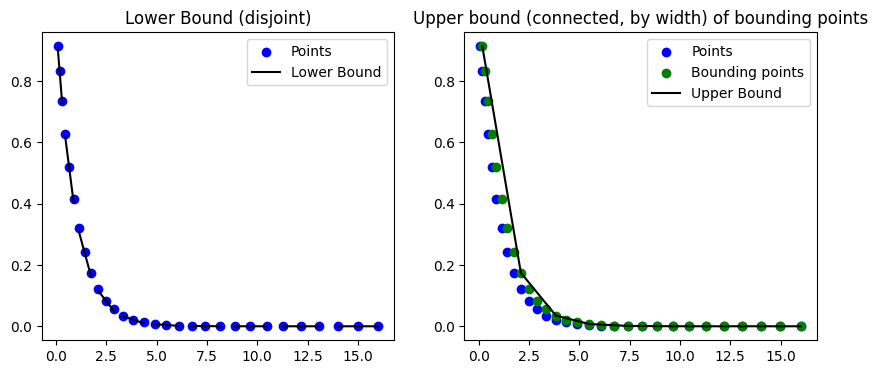

In [7]:
def extreme_points_indices(points, part, are_sorted):
    """
    Berechnet die indices der Punkte auf der Konvexen Hülle einer Menge von Punkten
    :param points: Menge von Punkten
    :param part: 'lower' für die untere Hülle, 'upper' für die obere Hülle
    :param are_sorted: True, falls die Punkte bereits nach x-Koordinate sortiert sind
    :return: Indices der Punkte auf der konvexen Hülle
    """
    points = np.array(points)
    if not are_sorted:
        points = points[np.argsort(points[:, 0])]

    # Funktion zur Berechnung des Kreuzprodukts
    def cross(o, a, b):
        return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])
    
    # Aufbau der unteren Hülle
    if part == 'lower':
        lower_indices = []
        for i, p in enumerate(points):
            while len(lower_indices) >= 2 and cross(points[lower_indices[-2]], points[lower_indices[-1]], p) <= 0:
                lower_indices.pop()
            lower_indices.append(i)
        return np.array(lower_indices)

    # Aufbau der oberen Hülle
    elif part == 'upper':
        upper_indices = []
        for i, p in enumerate(reversed(points)):
            while len(upper_indices) >= 2 and cross(points[upper_indices[-2]], points[upper_indices[-1]], p) <= 0:
                upper_indices.pop()
            upper_indices.append(i)
        return np.array(upper_indices)
    

def extreme_points(points, part, are_sorted):
    """
    Berechnet die Punkte auf der Konvexen Hülle einer Menge von Punkten
    :param points: Menge von Punkten
    :param part: 'lower' für die untere Hülle, 'upper' für die obere Hülle
    :param are_sorted: True, falls die Punkte bereits nach x-Koordinate sortiert sind
    :return: Punkte der konvexen Hülle
    """
    idx = extreme_points_indices(points, part, are_sorted)
    points = np.array(points)
    return points[idx]
    

def naive_po(points):
    """
    Berechnet die Pareto-optimalen Punkte einer Menge von Punkten auf naive Weise
    Naiv, weil wir das in der tatsächlichen Implementierung mit einem Heap machen würden
    :param points: Menge von Punkten
    :return: Pareto-optimale Punkte
    """
    points_array = np.array(points)
    
    sorted_points = points_array[np.lexsort((points_array[:, 1], points_array[:, 0]))]
    
    po_points = []
    
    min_y = float('inf')
    
    for point in sorted_points:
        x, y = point
        if y < min_y:
            po_points.append((x, y))
            min_y = y
    
    return np.array(po_points)




def shift_line(p1, p2, points, type):
    """
    Verschiebt eine Linie (p1, p2) entlang der y-Achse so, das keine Punkte in points oberhalb (bzw. unterhalb) der Linie liegen.
    :param p1: Startpunkt der Linie
    :param p2: Endpunkt der Linie
    :param points: Punkte, die die Linie schneiden soll
    :param type: 'lower' für einen lower bound, 'upper' für einen upper bound
    :return: Verschobene Linie: (p1', p2')
    """
    # Linie durch p1 und p2
    x1, y1 = p1
    x2, y2 = p2
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    
    # Bestimmen, wie weit die Linie nach verschoben werden muss
    max_shift = 0
    if type == 'lower':
        for x, y in points:
            # Berechne die y-Koordinate der Linie an der Stelle x
            y_on_line = m * x + b
            if y < y_on_line:
                shift = y_on_line - y
                if shift > max_shift:
                    max_shift = shift
        y1 -= max_shift
        y2 -= max_shift
    elif type == 'upper':
        for x, y in points:
            # Berechne die y-Koordinate der Linie an der Stelle x
            y_on_line = m * x + b
            if y > y_on_line:
                shift = y - y_on_line
                if shift > max_shift:
                    max_shift = shift
        y1 += max_shift
        y2 += max_shift
    return np.array([x1, y1]), np.array([x2, y2])

def create_disjoint_lb_lines_by_length(points, num_lines):
    """
    Erzeugt disjunkte lower bound Linien (disjunkt im Bezug auf die x-Intervalle) durch eine Menge von Punkten.
    :param points: Menge von Punkten
    :param num_lines: Anzahl der Linien
    :return: Liste von Linien
    """

    n = len(points)
    if n < num_lines + 1:
        raise ValueError("Nicht genügend Punkte für die angegebene Anzahl von Linien.")
    
    segments = []
    points_per_segment = n // num_lines
    remainder = n % num_lines
    
    start = 0
    for i in range(num_lines):
        end = start + points_per_segment
        if i < remainder:
            end += 1
        segments.append((points[start:end], start, end))
        start = end
    
    lines = []
    for segment, start, end in segments:
        if len(segment) < 2:
            continue
        p1 = segment[0]
        p2 = segment[-1]
        p1, p2 = shift_line(p1, p2, segment,type='lower')
        lines.append(((p1, p2), start, end-1))
    
    return lines

def create_connected_lines_by_width(points, num_lines, shift='none'):
    """
    Erzeugt verbundene Linien durch eine Menge von Punkten.
    Versucht die Linien so zu erzeugen, dass die x-Intervalle der Linien ungefähr gleich breit sind.
    :param points: Menge von Punkten
    :param num_lines: Anzahl der Linien
    :return: Liste von Linien
    """
    n = len(points)
    
    if n < num_lines + 1:
        raise ValueError("Nicht genügend Punkte für die angegebene Anzahl von Linien.")
    
    # Bestimme die Gesamtbreite
    total_width = points[-1][0] - points[0][0]
    segment_width = total_width / num_lines
    
    segments = []
    start_idx = 0
    
    for i in range(num_lines):
        end_idx = start_idx
        while end_idx < n and (points[end_idx][0] - points[start_idx][0]) < segment_width:
            end_idx += 1
        end_idx += 1
        if end_idx >= n:
            end_idx = n
        segments.append(points[start_idx:end_idx])
        start_idx = end_idx - 1
    
    lines = []
    for segment in segments:
        if len(segment) < 2:
            continue
        p1 = segment[0]
        p2 = segment[-1]
        if shift != 'none':
            p1, p2 = shift_line(p1, p2, segment, shift)
        lines.append((p1, p2))
    
    return lines

def create_lines_between_convex_points(points):
    """
    Erzeugt Linien zwischen den Punkten auf der konvexen Hülle. Jede Linie wird so weit wie möglich nach oben verschoben, bis sie auf den ersten Punkt trifft.
    :param points: Menge von Punkten
    :return: Liste von Linien
    """
    #TODO Convexe punkte und Segmente aus nur einem Punkt behandeln

    # Berechne die Indices der Punkte auf der konvexen Hülle
    convex_hull_indices = extreme_points_indices(points, 'lower', True)

    lines = []
    # for i in convex_hull_indices:
    #     lines.append(((points[i], points[i]),i,i))

    for i in range(len(convex_hull_indices) - 1):
        # Bestimme die Punkte des aktuellen Segments
        start_idx = convex_hull_indices[i] + 1
        end_idx = convex_hull_indices[i + 1]
        segment_points = points[start_idx:end_idx]
        
        if start_idx == end_idx or start_idx == end_idx-1: #
            continue
        
        # Bestimme die konvexen Punkte, die die Linie definieren
        # p1 = points[convex_hull_indices[i]]
        # p2 = points[convex_hull_indices[i + 1]]
        p1 = segment_points[0]
        p2 = segment_points[-1]
        
        # Passe die x-Koordinaten der Linie an, sodass sie mit dem ersten und letzten Punkt des Segments beginnt/endet
        p1[0], p2[0] = segment_points[0][0], segment_points[-1][0]
        
        # Verschiebe die Linie so weit wie möglich nach unten 
        # #TODO verbessern (momentan umständlich, da wir die Linie erst nach oben verschieben und dann wieder nach unten)
        p1, p2 = shift_line(p1, p2, segment_points, 'upper')
        p1, p2 = shift_line(p1, p2, segment_points, 'lower')
        
        
        lines.append(((p1, p2),start_idx,end_idx-1))
    
    return lines



def extreme_points_of_segments(points,num_lines, part):
    #Annahme: points sind sortiert (nach x und y)
    
    n = len(points)
    if n < num_lines + 1:
        raise ValueError("Nicht genügend Punkte für die angegebene Anzahl von Linien.")
    
    segments = []
    points_per_segment = n // num_lines
    remainder = n % num_lines
    
    start = 0
    for i in range(num_lines):
        end = start + points_per_segment
        if i < remainder:
            end += 1
        segments.append((points[start:end], start, end))
        start = end
    
    # create empty array
    all_extreme_points = np.empty((0,2))

    for segment, start, end in segments:
        if len(segment) < 2:
            continue
        segment_extreme_points = extreme_points(segment, part, True)
        all_extreme_points = np.vstack((all_extreme_points, segment_extreme_points))
    
    return all_extreme_points


def get_upper_bounding_points(points):
    points = np.array(points)
    # Überprüfe, ob das Array mindestens 2 Punkte enthält
    if len(points) < 2:
        raise ValueError("Das Array muss mindestens 2 Punkte enthalten")
    
    # Extrahiere die x- und y-Werte
    x_values = points[:, 0]
    y_values = points[:, 1]
    
    # Erstelle das neue Array
    new_array = np.zeros((len(points) - 1, 2))
    
    # Übernehme die verschobenen x-Werte und die y-Werte
    new_array[:, 0] = x_values[1:]  # x-Werte um 1 verschoben
    new_array[:, 1] = y_values[:-1]  # y-Werte des alten Arrays
    
    return new_array



def test_some_functions():
    """ Hilfsfunktion zum Testen von bound Funktionen usw."""
    num_plots = 2

    points = [(x, 1/math.exp(x)) for x in (np.linspace(0.3, 4, 30)**2)]
    segments = create_disjoint_lb_lines_by_length(points, 10)
    fig, axs = plt.subplots((num_plots + 1) // 2, 2, figsize=(10,3*(num_plots + 1) // 2))
    axs = axs.flatten()

    # 0. subplot
    lines = [segment[0] for segment in segments]
    axs[0].scatter(*zip(*points), color = 'b',label='Points')
    [axs[0].plot([p1[0], p2[0]], [p1[1], p2[1]], color='black', zorder=5) for p1, p2 in lines]
    axs[0].plot([], [], color='black', zorder=5,label='Lower Bound')
    axs[0].set_title('Lower Bound (disjoint)')
    axs[0].legend()

    # 1. subplot
    bounding_points = get_upper_bounding_points(points)
    ub_lines = create_connected_lines_by_width(bounding_points, 10, shift='upper')
    axs[1].scatter(*zip(*points), color = 'b',label='Points')
    axs[1].scatter(*zip(*bounding_points), color = 'g',label='Bounding points')
    [axs[1].plot([p1[0], p2[0]], [p1[1], p2[1]], color='black', zorder=5) for p1, p2 in ub_lines]
    axs[1].plot([], [], color='black', zorder=5,label='Upper Bound')
    axs[1].set_title('Upper bound (connected, by width) of bounding points')

    axs[1].legend()


    plt.show()

    

test_some_functions()

## Bound & Heuristik Funktionen

In [8]:
num_lower_lines = 30
num_upper_lines = 100

def smaller_lower(points):
    '''
    Funktion die die lower bounds für die kleinere Punktemenge berechnet
    '''
    # Berechne lower bound Linien, die alle ca. gleich viele Punkte beschränken
    return create_disjoint_lb_lines_by_length(points, num_lower_lines)


def bigger_lower(points):
    '''
    Funktion die die lower bounds für die größere Punktemenge berechnet
    '''
    # Berechne lower bound Linien, die alle ca. gleich viele Punkte beschränken
    return create_disjoint_lb_lines_by_length(points, num_lower_lines)

def po_heuristic(points1, points2):
    '''
    Funktion die die Heuristik der PO-Punkte berechnet
    '''
    # Berechne die extremen Punkte verschiedener Segmente
    points1_lower = extreme_points_of_segments(points1,num_lower_lines, 'lower')
    points2_lower = extreme_points_of_segments(points2,num_lower_lines, 'lower')

    # Kombiniere diese Punkte paarweise
    points1_lower = np.array(points1_lower)
    points2_lower = np.array(points2_lower)
    combinations = np.array([points1_lower[i] + points2_lower[j] for i in range(len(points1_lower)) for j in range(len(points2_lower))])

    # Berechne die Pareto-optimalen Punkte der Kombinationen
    print("--------------------")
    print(f"Berechne naiv die PO-Menge von {len(combinations)} Punkten ({len(combinations) / (len(points1) * len(points2))*100:.2g}% aller möglichen Kombinationen))")
    combinations = naive_po(combinations)
    return combinations


def po_upper(points): 
    '''
    Funktion die die upper bounds für die größere Punktemenge berechnet
    '''
    # Berechne die Bounding points
    bounding_points = get_upper_bounding_points(points)

    # Berechne upper bound Linien zu diesen bounding points, die alle ca. gleich große x-Intervalle abdecken
    ub_lines = create_connected_lines_by_width(bounding_points, num_upper_lines, shift='upper')
    return ub_lines


## (Interaktives) Plotten der Results

In [9]:
from ipywidgets import Checkbox, interact
def plot_result_interactive(plot_calc_lines=True,plot_skip_lines=True,plot_ub=True,plot_heuristic_boxes=False):
    global heuristic_result
    heuristic_points, po_ub, smaller_lb, bigger_lb, skip_lines, calc_lines, bigger_df, smaller_df = heuristic_result
    bigger_points = bigger_df[['weight_0', 'weight_1']].to_numpy()
    smaller_points = smaller_df[['weight_0', 'weight_1']].to_numpy()

    fig1, ax = plt.subplots(1, 1, figsize=(10, 5))

    # PO-Heuristik Menge und dessen Upper Bound plotten
    ax.scatter(heuristic_points[:, 0], heuristic_points[:,1], label = 'PO heuristic points')
    
    ax.set_title('PO-Heuristic with upper bound')
    ax.set_xlabel('weight0')
    ax.set_ylabel('weight1')


    #skip line
    if plot_skip_lines:
        ax.plot([], [], 'b',label='Skipped lb combinations')
        for lb_line in skip_lines:
            ax.plot([lb_line[0][0], lb_line[1][0], lb_line[2][0]], [lb_line[0][1], lb_line[1][1], lb_line[2][1]], 'b')
    #calc line
    if plot_calc_lines:
        ax.plot([], [], 'orange',label='Calc lb combinations')
        for lb_line in calc_lines:
            ax.plot([lb_line[0][0], lb_line[1][0], lb_line[2][0]], [lb_line[0][1], lb_line[1][1], lb_line[2][1]], 'orange')

    # die heuristik boxen plotten
    if plot_heuristic_boxes:
        rectangle = plt.Rectangle((0, 0), 0, 0, edgecolor='green', facecolor='lightgreen',alpha=0.5, label='heuristic boxes')
        ax.add_patch(rectangle)

        for i in range(len(heuristic_points) - 1):
            x0, y0 = heuristic_points[i]
            x1, y1 = heuristic_points[i + 1]
            
            lower_left_x = min(x0, x1)
            lower_left_y = min(y0, y1)
            width = abs(x1 - x0)
            height = abs(y1 - y0)
            
            rectangle = plt.Rectangle((lower_left_x, lower_left_y), width, height, edgecolor='green', facecolor='lightgreen',alpha=0.5)
            ax.add_patch(rectangle)

    if plot_ub:
        ax.plot([], [], 'r', label='PO heuristic upper bound')
        for line in po_ub:
            ax.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], 'r')
    
    ax.legend()
    plt.show()

    fig2, axs = plt.subplots(1, 3, figsize=(10, 5))

    smaller_extreme_points_of_segments = extreme_points_of_segments(smaller_points,num_lower_lines, 'lower')
    axs[0].scatter(smaller_points[:,0], smaller_points[:,1], label='solution points')
    axs[0].scatter(*zip(*smaller_extreme_points_of_segments), label='convex solution points of segments',c='purple')


    axs[0].plot([], [], 'r',label='Lower Bound')
    for line in smaller_lb:
        (A, B), _, _ = line
        axs[0].plot([A[0], B[0]], [A[1], B[1]], 'r')
    axs[0].set_title('Smaller Points')
    axs[0].set_xlabel('weight0')
    axs[0].set_ylabel('weight1')
    axs[0].legend()

    bigger_extreme_points_of_segments = extreme_points_of_segments(bigger_points,num_lower_lines, 'lower')
    axs[1].scatter(bigger_points[:,0], bigger_points[:,1], label='solution points')
    axs[1].scatter(*zip(*bigger_extreme_points_of_segments), label='convex solution points of segments',c='purple')
    
    axs[1].plot([], [], 'r',label='Lower Bound')
    for line in bigger_lb:
        (A, B), _, _ = line
        axs[1].plot([A[0], B[0]], [A[1], B[1]], 'r')
    axs[1].set_title('Bigger Points')
    axs[1].set_xlabel('weight0')
    axs[1].set_ylabel('weight1')
    axs[1].legend()

    axs[2].scatter(smaller_points[:,0], smaller_points[:,1], label='smaller solution points',c='blue', s=15, alpha=0.5)
    axs[2].plot([], [], c="lightblue",label='Smaller Lower Bound')
    for line in smaller_lb:
        (A, B), _, _ = line
        axs[2].plot([A[0], B[0]], [A[1], B[1]], 'lightblue')

    axs[2].scatter(bigger_points[:,0], bigger_points[:,1], label='bigger solution points',c='green', s=15, alpha=0.5)
    axs[2].plot([], [], 'lightgreen',label='Bigger Lower Bound')
    for line in bigger_lb:
        (A, B), _, _ = line
        axs[2].plot([A[0], B[0]], [A[1], B[1]], 'lightgreen')

    axs[2].set_title('Smaller and Bigger Points')
    axs[2].set_xlabel('weight0')
    axs[2].set_ylabel('weight1')
    axs[2].legend()

        
    #plt größer machen
    fig2.set_size_inches(15, 6)
    fig2.tight_layout()
    # plt.close()
    plt.show()

## Daten laden und Tester + Visualisierung ausführen

In [10]:
def heuristic_test_entry(entry_folder):
    '''
    Übernimmt das Einlesen der Daten und testet die Heuristik
    '''
    print(f"Plotte entry \"{entry_folder.split('/')[-1]}\" von node \"{entry_folder.split('/')[-2]}\" aus Benchmark \"{entry_folder.split('/')[-5]}\"")
    
    # Load the data
    bigger_df = pd.read_csv(f'{entry_folder}/first.csv')
    smaller_df = pd.read_csv(f'{entry_folder}/second.csv')
    # i_df = pd.read_csv(f'{entry_folder}/i.csv')

    #if first_df is smaller then second_df, swap them
    if bigger_df.shape[0] < smaller_df.shape[0]:
        bigger_df, smaller_df = smaller_df, bigger_df
        # rename the columnds in i_df
        # i_df.rename(columns={'first_index': 'second_index', 'second_index': 'first_index'}, inplace=True)

    # rename i_df and columns to smaller and bigger
    # i_df.rename(columns={'first_index': 'bigger_index', 'second_index': 'smaller_index'}, inplace=True)

    # measure the time
    heuristic_points, po_ub, smaller_lb, bigger_lb, skip_lines, calc_lines = heuristic_test(bigger_df, smaller_df, bigger_lower, smaller_lower, po_heuristic, po_upper)

    global heuristic_result
    heuristic_result = heuristic_points, po_ub, smaller_lb, bigger_lb, skip_lines, calc_lines, bigger_df, smaller_df
    # Layout definieren

    interact(plot_result_interactive)
    

def heuristic_test_node(node_id, num_entries):
    node_folder = f"{dataLog_folder}/joinDetailed/{node_id}"
    entry_folders = np.random.choice(os.listdir(node_folder), num_entries, replace=False)
    for entry_folder in entry_folders:
        
        heuristic_test_entry(node_folder + "/" + entry_folder)


## Aufruf des Testers


In [11]:
%matplotlib widget
# die Daten us diesem dataLog_folder gehören zu einem langsamen join-node (ca. 10 Minuten / Eintrag)
dataLog_folder = "./osterloh_long_joinNode/dataLogs" 

# heuristic_test_entry(f"{dataLog_folder}/joinDetailed/15181/2") 
# 15181/2 78% (lower disjoint len 30, upper connected width 100 of bounding points, heuristic: po of combined of maximal of segments)

# heuristic_test_entry(f"{dataLog_folder}/joinDetailed/15181/2416") 
# 15181/2416 76% (lower disjoint len 30, upper connected width 100 of bounding points, heuristic: po of combined of maximal of segments)

# heuristic_test_entry(f"{dataLog_folder}/joinDetailed/15181/10220") 
# 15181/10220 79% (lower disjoint len 30, upper connected width 100 of bounding points, heuristic: po of combined of maximal of segments)

# heuristic_test_node(15181,2+3*13)

# Heuristik an drei nodes (an jeweils einem zufälligen Eintrag) testen


heuristic_test_node("15181",1)
heuristic_test_node("2_3597",1)
heuristic_test_node("2_7467",1)

Plotte entry "8201" von node "15181" aus Benchmark "osterloh_long_joinNode"
--------------------
Berechne naiv die PO-Menge von 264702 Punkten (0.031% aller möglichen Kombinationen))
--------------------
Laufzeit (ohne plotten): 0.43s
--------------------
Übersprungener Punkte: 76%  (639910551 von 842002425)
Übersprungener Kombinationen: 76%  (684 von 900)
--------------------
Heuristik relative Größe: 0.0011%  (8924 von 842002425)
--------------------
Smaller Points: 24915
Bigger Points: 33795


interactive(children=(Checkbox(value=True, description='plot_calc_lines'), Checkbox(value=True, description='p…